<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Gravity Assist

### Example - Mechanics
<section class="post-meta">
By Eilif Sommer Øyre, Jonas Tjemsland and Jon Andreas Støvneng
</section>
Last edited: July 9th 2018 
___

## Introduction
In orbital dynamics, gravity assist (or gravitational slingshot) is the maneuver of altering the velocity of a spacescraft using the relative motion of a large celestial body. This means changing the velocity and/or direction relative to a third reference system without use of artificial induced forces. In this notebook we will simulate a gravity assist by doing a spacecraft planet flyby. An animation is included at the end.

The first gravity assist maneuver was performed by the Mariner-10 probe at Venus on February 5, 1974 [[1]](#rsc) on its way to Mercury.

The Cassini-Huygens probe used multiple gravity assists to reach Saturn. Passing Venus twice, then Earth and finally Jupiter before arriving at Saturn 6.7 years after the launch in 1997. A Hohmann transfer would have required only 6 years, but would use 16 km/s of propulsive change in velocity compared to only 2 km/s using the gravity assist maneuvers. 

By looking at figure [1](#im1) you can probably guess that performing multiple gravity assist maneuvers requires certain seldom alignment of the planets to reach a particular destination in the solar system.

<a title="Cassini Probe Voyage" href="https://saturn.jpl.nasa.gov/system/resources/detail_files/1776_Cassini_interplanet_trajectory.png"><img width=400 alt="Cassini-Hugyens Trajectory" src="https://www.numfys.net/media/notebooks/images/Cassini_interplanet_trajectory.png	"></a>
**Figure 1:** *Cassini-Huygens path through the solar system. A total of four gravity assist maneuvers, passing Venus twice, the Earth an Jupiter on a 6.7 year long journey to Saturn.*

## Theory

When considering a gravity assist, the spacecraft approaches the assisting planet in an hyperbolic orbit. Because of the huge mass difference between a planet and the passing spacecraft, the planet does not react by any measurable amount to the encounter. You may call it an elastic collision against a fixed planet. Then, relative to the planet, the spacecraft arrival velocity is equal to the departure velocity, as required by consvervation of energy, but the direction of the velocity may be altered by the ecounter. This arrival velocity is often called hyperbolic excess velocity. It is equal to the remaining velocity of the spacecraft after escaping the gravitational influence of the planet.

In conclusion, in a frame of reference where the planet is moving (e.g. the star it's orbiting), the spacecraft has a change in kinetic energy and speed. The change in velocity can be written as (see [[1]](#rsc) section 4.5.6)

\begin{equation}
    \Delta V = 2V_{\infty} \mathrm{sin}\big( \frac{\Psi}{2} \big)
\label{change}
\end{equation}

$\Psi$ is the deflection angle of the flyby and $V_{\infty}$ is the hyperbolic excess velocity, see figure [2](#im2). To maximize the change in velocity, we maximize the deflection angle.

<a id="im2" title="Gravitational slingshot sketch">
<img width=400 alt ="Slingshot"
src="https://www.numfys.net/media/notebooks/images/slingshot.png" ></a>

**Figure 2:** *Deflection angle $\Psi$ and hyperbolic excess velocity $V_{\infty}$ of a hyperbolic orbit.*

The force acting on the spacecraft is gravitational force from the planet,

$$ \mathbf{F_{G}} =  \frac{GM_pM_s}{\mathbf{r}^2}\text{.} $$

This can be decomposed into four first order differential equations:

\begin{equation}
        \frac{dv_x}{dt} = - \frac{G M_S x}{r^3}\text{,} \hspace{1cm} \frac{dx}{dt} = v_x,
\label{first_order}
\end{equation}

\begin{equation}
\frac{dv_y}{dt} = - \frac{G M_S y}{r^3} \text{,} \hspace{1cm} \frac{dy}{dt} = v_y \text{.}
\end{equation}

When simulating the gravity assist we will solve these equations computationally for both the spacecraft and the planet, giving us the position in cartesian coordinates at any time $t$.

## Numerical implementation
To calculate the motion of the spacecraft and the planet we solve their equations of motion using the *Euler-Cromer method*, a semi-implicit Euler method. Applying this method on our pairs of first order differential equations (\ref{firs_order}) we get a discrete solution by iterating

\begin{equation}
    v_{x,i+1} = v_{x,i} - \frac{GM x_i}{r_i^3} \Delta{t}, \\ 
    x_{i+1} = x_i + v_{x,i+1} \Delta{t}, \\ 
    v_{y,i+1} = v_{y,i} - \frac{GM y_i}{r_i^3} \Delta{t}, \\
    y_{i+1} = y_i + v_{y,i+1} \Delta{t}.
\end{equation}

Here, $v_{x, i}$ is the velocity in $x$-direction at time $i\Delta{t}$ and $r_i$ is the distance between the spacecraft and the planet. $M$ is the mass of either the spacecraft or the planet depending on whose position you are iterating.

First, we import necessary libraries, choose a nice plot style and set the figure parameters.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
import numpy as np
plt.style.use("bmh")

In [2]:
# Set common figure parameters
newparams = {'axes.labelsize': 11, 'axes.linewidth': 1, 'savefig.dpi': 200,
             'lines.linewidth': 1, 'figure.figsize': (12, 6),
             'ytick.labelsize': 11, 'xtick.labelsize': 11,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,
             'legend.fontsize': 12, 'legend.frameon': True,
             'legend.handlelength': 1.5, 'axes.titlesize': 15}
plt.rcParams.update(newparams)

Next, we set the initial conditions. The planet's mass is set to roughly the mass of Saturn, and its velocity relative to the star is set to 30 km/s, equal to the orbital speed of Earth. The remaining initial conditions is chosen empirically to get a satisfying gravity assist effect.

In [3]:
m1 = 100          # Spacecraft mass
m2 = 1E26         # Planet mass
G = 6.67408E-11   # Gravitational constant
GM1 = G*m1
GM2 = G*m2

# Initial position and velocity.
# z0 = [    x1,    y1,    x2,    y2,   vx1,   vy1,    vx2,    vy2]
z0 =  [ -8E6,  100E6,     0, 200E6,  30E3,  30E3,   30E3,     0,]
 
# Absolute value of relative position vector 
r = np.sqrt((z0[0] - z0[2])**2 + (z0[1] - z0[3])**2)     
r0 = [r]

# Mechanical energy (kinetic, potential)
# e0 = [ke1, ke2, pe1, pe2, potential energy of system]
e0 = [0.5 * m1 * (z0[4]**2 + z0[5]**2), 
      0.5 * m2 * (z0[6]**2 + z0[7]**2), 
      -GM2*m1/r,
      -GM1*m2/r, ]
U1 = 0
U2 = -GM2*m1/r
e0.append(U1 + U2)

Then, we use the Euler-Cromer method to calculate the trajectories of the objects. We also calculate the kinetic energy, potential energy and angular momentum for each iteration. Finally, we plot the orbit.

Timestep:	0.600000


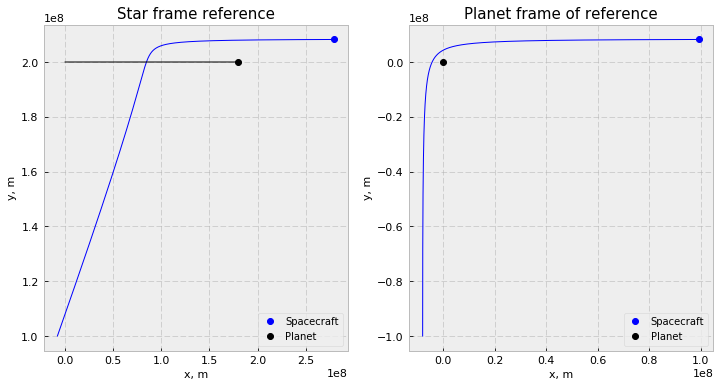

In [4]:
simulationDuration = 6000       # Seconds
n = 10000                       # Number of datapoints
# time step and initial time
h = simulationDuration/n
print("Timestep:\t%f"%h)
t = 0

# Allocate matrices
Z = np.zeros((len(z0), n + 1))
Z[:, 0] = np.array(z0)
E = np.zeros((len(e0), n + 1))
E[:, 0] = np.array(e0)
R = np.zeros((n + 1))
R[0] = r

# Nummerical integration
def eulerCromerStep(pos, vel, timeStep):
    newPos = []
    for j in range(len(pos)):
        newPos.append(pos[j] + vel[j] * timeStep)
    return newPos


# Iteration loop
for i in range(n):
    # Mass 1 velocity
    Z[4, i + 1] = Z[4, i] - GM2*(Z[0, i] - Z[2, i])*h/r**3 
    Z[5, i + 1] = Z[5, i] - GM2*(Z[1, i] - Z[3, i])*h/r**3

    # Mass 2 velocity
    Z[6, i + 1] = Z[6, i] - GM1*(Z[2, i] - Z[0, i])*h/r**3
    Z[7, i + 1] = Z[7, i] - GM1*(Z[3, i] - Z[1, i])*h/r**3

    # Set new positions using Euler-Cramer method
    Z[:4, i + 1] = eulerCromerStep(Z[:4, i], Z[4:10, i + 1], h)

    # New relative position
    r = np.sqrt((Z[0, i+1] - Z[2, i+1])**2 + (Z[1, i+1] - Z[3, i+1])**2)
    R[i + 1] = r

    # Angular momentum and mechanical energy
    ke1, pe1 = 0.5 * m1 * (Z[4, i+1]**2 + Z[5, i+1]**2), -GM2*m1/r
    ke2, pe2 = 0.5 * m2 * (Z[6, i+1]**2 + Z[7, i+1]**2), -GM1*m2/r
    U1 = 0
    U2 = -GM2*m1/r
    E[:, i + 1] = [ke1, ke2, pe1, pe2, U1+U2]

    # Increment time
    t += h


fig = plt.figure()
ax = fig.add_subplot(121, title="Star frame reference")
ax.set_xlabel("x, m")
ax.set_ylabel('y, m')
ax.plot(Z[0], Z[1], color='blue')
ax.plot(Z[0][-1], Z[1][-1], 'o', label='Spacecraft', color="blue")
ax.plot(Z[2], Z[3], color='black')
ax.plot(Z[2][-1], Z[3][-1],  'o', label='Planet', color="black")
plt.legend(loc="lower right", numpoints=1, fontsize=10)

ax = fig.add_subplot(122, title="Planet frame of reference")
ax.set_xlabel("x, m")
ax.set_ylabel('y, m')
ax.plot(Z[0] - Z[2], Z[1] - Z[3], color='blue')
ax.plot(Z[0][-1] - Z[2][-1], Z[1][-1] - Z[3][-1], 'o', label='Spacecraft', color="blue")
ax.plot(0, 0, 'o', label='Planet', color="black")
plt.legend(loc="lower right", numpoints=1, fontsize=10)

plt.show()

As seen from the plots, the spacecraft changes its direction after the flyby. The absolute velocity relative to the star is also changed, which is more easily seen in the animation further down. To see this, we first print out values that verifies the velocity change. In addition, we compare the results with the analytical $\Delta V$ with the corresponding deflection angle $\Psi$ and excess velocity $V_{\infty}$.

In [5]:
# Velocity of the spacecraft relative to the star
# Initial
vx0_star = z0[4]
vy0_star = z0[5]
# Final
vxf_star = Z[4][-1]
vyf_star = Z[5][-1]

# Velocity of the spacecraft realtive to the planet
# Initial
vx0_planet = z0[4] - z0[6]
vy0_planet = z0[5] - z0[7]
# Final
vxf_planet = Z[4][-1] - Z[6][-1]
vyf_planet = Z[5][-1] - Z[7][-1]

initialAbsoluteVelocity = np.sqrt(vx0_star**2 + vy0_star**2)
finalAbsoluteVelocity = np.sqrt(vxf_star**2 + vyf_star**2)
excessVelocity = np.sqrt((vx0_planet)**2 + (vy0_planet)**2)
deflectionAngle = np.arctan2(vy0_planet, vx0_planet)  -  np.arctan2(vyf_planet, vxf_planet)
analyticDeltaV = 2*excessVelocity*np.sin(deflectionAngle/2)
numericalDeltaV = np.sqrt((vxf_star - vx0_star)**2 + (vyf_star - vy0_star)**2)

print("\nInitial velocity [m/s]:\nx:\t%.1f\ny:\t%.1f\nabs:\t%.1f"%(vx0_star, 
                                                                   vy0_star, 
                                                                   initialAbsoluteVelocity))
print("\nFinal velocity [m/s]:\nx:\t%.1f\ny:\t%.1f\nabs:\t%.1f"%(vx0_planet, 
                                                                 vy0_planet, 
                                                                 finalAbsoluteVelocity))
print("\nNumerical delta V [m/s]:\t%.1f"%(numericalDeltaV))
print("Analytical delta V [m/s]:\t%.1f"%(analyticDeltaV))
print("Deflection angle [degrees]:\t%.1f"%(deflectionAngle*180/np.pi))


Initial velocity [m/s]:
x:	30000.0
y:	30000.0
abs:	42426.4

Final velocity [m/s]:
x:	0.0
y:	30000.0
abs:	60011.9

Numerical delta V [m/s]:	42386.2
Analytical delta V [m/s]:	42377.8
Deflection angle [degrees]:	89.9


There has been a significant change in the velocity. The numerical value is approximately equal to the analytical from \eqref{change}. This can also be seen when plotting the kinetic energy.

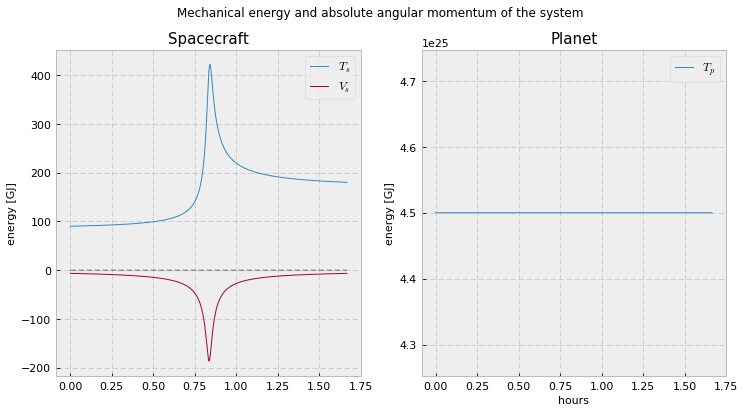

In [6]:
fig = plt.figure("Data")
abciss = np.linspace(0, simulationDuration, n + 1)/3600
ax = fig.add_subplot(121, title="Spacecraft")
ax.plot(abciss, [0 for n in range(len(abciss))], '--', color='black', linewidth=0.5)
ax.plot(abciss, E[0]/1E9, label=r'$T_s$')
ax.plot(abciss, E[2]/1E9, label=r'$V_s$')
ax.set_ylabel("energy [GJ]")
plt.legend(loc='best')
ax = fig.add_subplot(122, title="Planet")
ax.plot(abciss, E[1]/1E9, label=r'$T_p$')
plt.suptitle("Mechanical energy and absolute angular momentum of the system")
ax.set_xlabel("hours")
ax.set_ylabel("energy [GJ]")
plt.legend(loc='best')
plt.savefig("threeBody-data2.png")
plt.show()

Notice how the potential returns the initial value while the kinetic increases permanently. The planets kinetic energy remains constant, as expected.

Play around with different initial values of the planet and spacecraft. Can you make the deflection angel $\Psi = \pi$? 

At last, we make an animation.

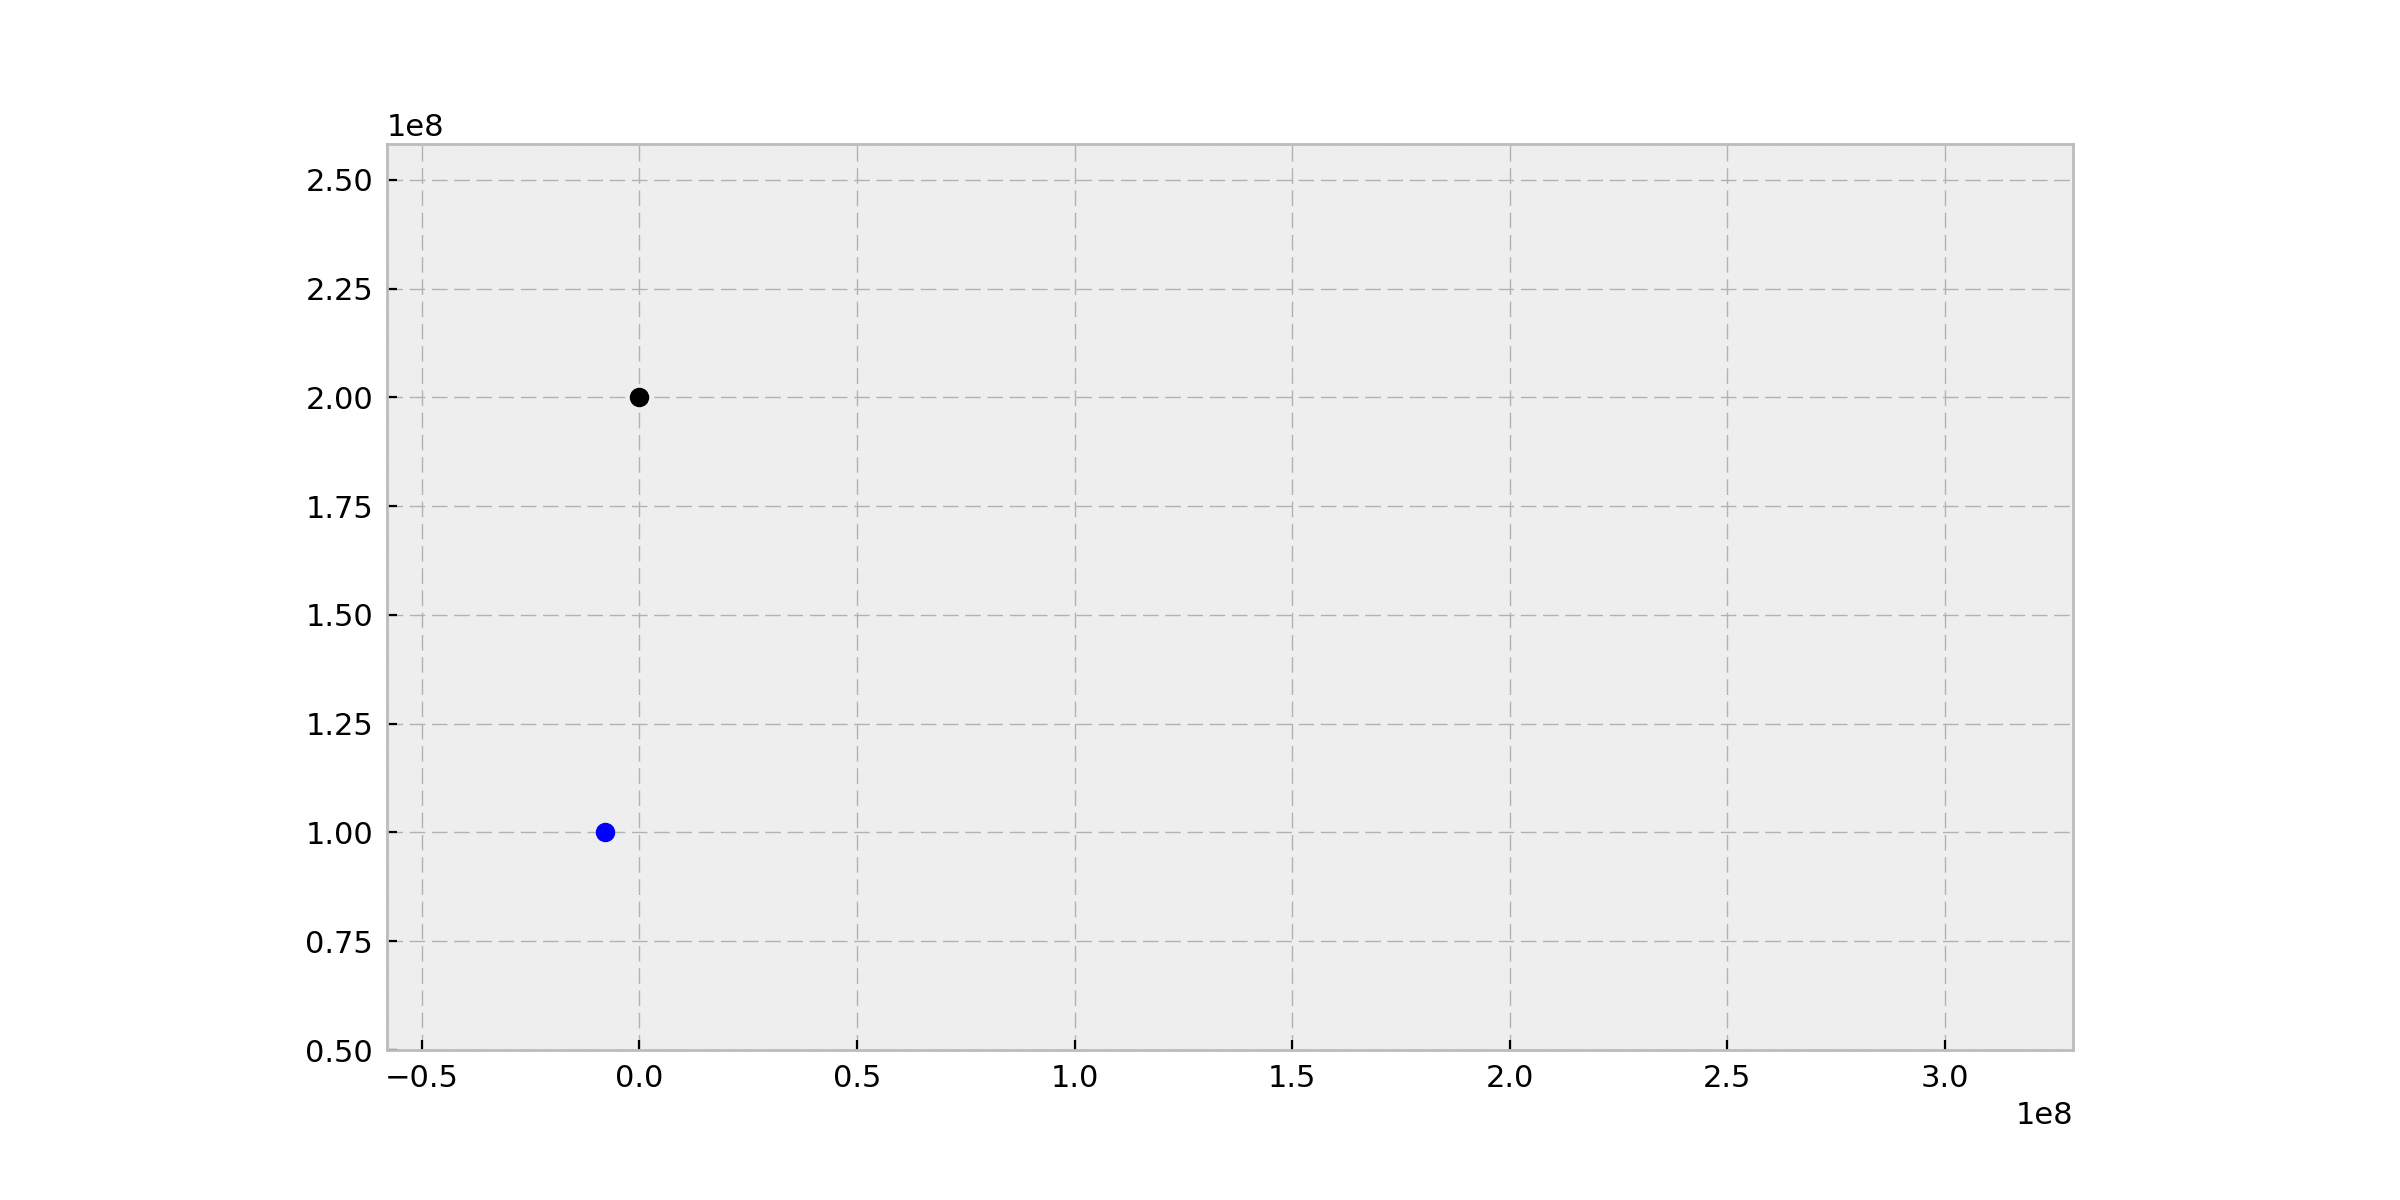

In [7]:
fig = plt.figure()
ax = plt.axes(xlim=(np.amin([np.amin(Z[0]), np.amin(Z[2])]) - 0.5E8, 
                    np.amax([np.amax(Z[0]), np.amax(Z[2])]) + 0.5E8), 
            ylim=(np.amin([np.amin(Z[1]), np.amin(Z[3])]) - 0.5E8, 
                  np.amax([np.amax(Z[1]), np.amax(Z[3])]) + 0.5E8))
ax.set_aspect('equal')

# Defining different elements in the animation
tail1, = ax.plot(Z[0][0] , Z[1][0], color="blue")           # Tail obj. 1
tail2, = ax.plot(Z[2][0] , Z[3][0], color="black")          # Tail obj. 2
body1, = ax.plot(Z[0][0] , Z[1][0], 'bo', color="blue")     # Obj. 1
body2, = ax.plot(Z[2][0] , Z[3][0], 'bo', color="black")    # Obj. 2

# Calculate the number of frames
FPS = 15
framesNum = int(FPS*5)

# Animation function. This is called sequentially
def animate(j):
    i = j*int(n/framesNum)
    tail1.set_data(Z[0][:i], Z[1][:i])
    tail2.set_data(Z[2][:i], Z[3][:i])
    body1.set_data(Z[0][i], Z[1][i])
    body2.set_data(Z[2][i], Z[3][i])

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=framesNum)

# Save animation.
# If this don't work for you, try using another writer 
# (ffmpeg, mencoder, imagemagick), or another file extension
# (.mp4, .gif, .ogg, .ogv, .avi etc.). Make sure that you
# have the codec and the writer installed on your system.
anim.save('gravityAssist.gif', writer='imagemagick', fps=FPS)

# Close plot
plt.close(anim._fig)

# Display the animation
with open('gravityAssist.gif', 'rb') as file:
    display(Image(file.read()))

<a id="rsc"></a>
## References and further reading
<a>[1]</a>: Malcolm Macdonald, Viorel Badescu. The International Handbook of Space Technology. Springer-Verlag Berlin Heidelberg, 2014. <br />
<a>[2]</a>: NASA, CASSINI, saturn.jpl.nasa.gov, 2018.